<h1 align="center"><font color='blue'> <span style="font-family:Roboto Mono;"> Car Detection Using YOLOv11 </span> </font></h1> 

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 15.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import os  
import pandas as pd  
import numpy as np  
import random

import cv2  
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import seaborn as sns  
from sklearn.model_selection import train_test_split 
from glob import glob
import shutil
from tqdm import tqdm
 
from PIL import Image
from ultralytics import YOLO


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
RANDOM_STATE = 42
VAL_SIZE = 0.2

In [4]:
car_data = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
car_data.sample(5)

image        xmin        ymin        xmax        ymax
394   vid_4_3180.jpg  187.342981  193.881918  373.218524  255.503539
393   vid_4_3140.jpg  183.429812  190.947555  305.227207  240.342664
437   vid_4_6280.jpg    0.000000  199.750643   38.153401  225.670849
500   vid_4_9060.jpg   10.339403  196.352817   63.021122  223.917584
51   vid_4_12260.jpg  282.726483  184.100708  321.369030  217.356821

In [5]:
car_data['image'].value_counts().head(5)

image
vid_4_26460.jpg    7
vid_4_6240.jpg     6
vid_4_26420.jpg    5
vid_4_26380.jpg    5
vid_4_26400.jpg    5
Name: count, dtype: int64

The most number of cars in one photo is 7.

In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB


The csv-file contains the name of the jpg image and the bbox coordinates (xmin, ymin, xmax, ymax). There are 559 images in total.

In [7]:
train_path = '/kaggle/input/car-object-detection/data/training_images/'
test_path = '/kaggle/input/car-object-detection/data/testing_images/'
train_images = os.listdir(train_path)
test_images = os.listdir(test_path)
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 1001
Number of test images: 175


Probably there are no cars in some images, therefore the number of bboxes are less than number of images.

In [8]:
# Visualizing random images with bounding boxes
def plot_images_with_boxes(images_path, df):
    # choose random image from dataset
    plt.figure(figsize=(20,20))
    imgs = random.sample(os.listdir(images_path), 5)

    for img in imgs:
        img_name = os.path.basename(images_path+img)
        img = cv2.imread(images_path+img_name)
        print(img.shape)

        boxes = df[df['image'] == img_name]          
        for _, box in boxes.iterrows():
            cv2.rectangle(img, 
                          (int(box['xmin']), int(box['ymin'])), 
                          (int(box['xmax']), int(box['ymax'])), 
                          (0, 255, 0), 2)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_name)
        plt.axis('off')
        plt.show()

(380, 676, 3)


<Figure size 2000x2000 with 0 Axes>

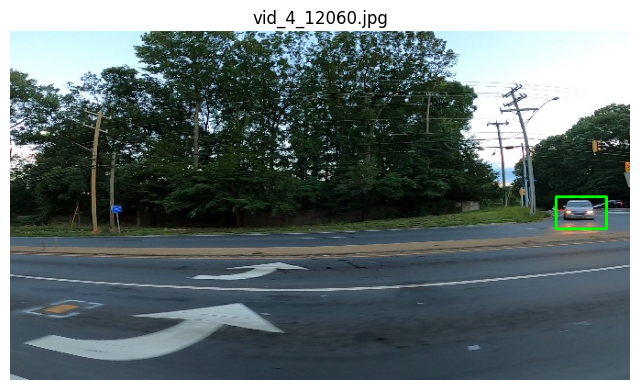

(380, 676, 3)


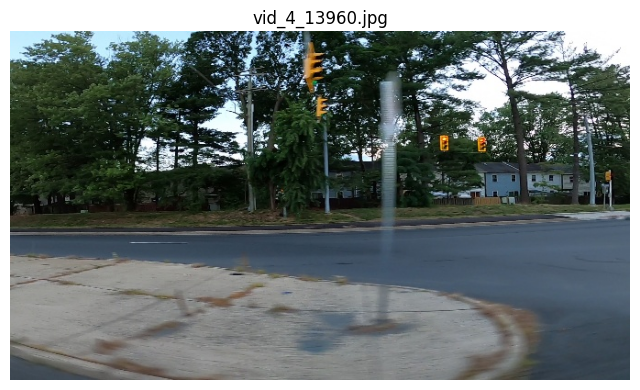

(380, 676, 3)


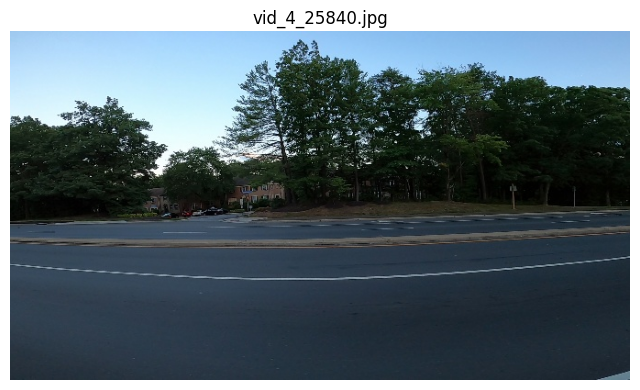

(380, 676, 3)


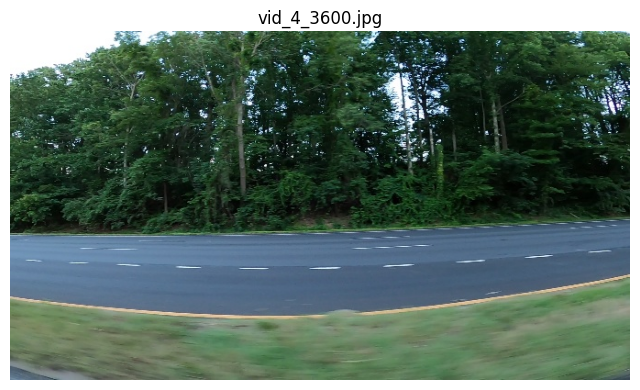

(380, 676, 3)


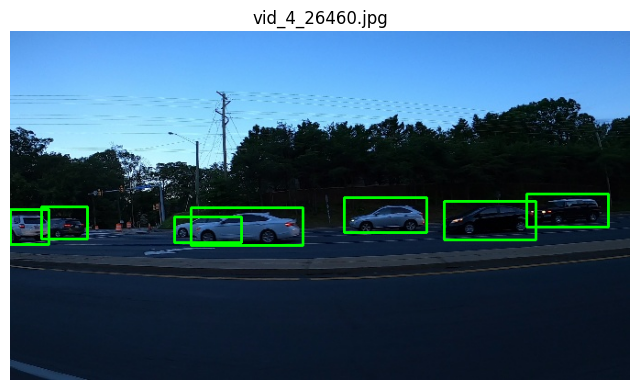

In [9]:
plot_images_with_boxes(train_path, car_data)

<h2 align="center"><font color='green'> <span style="font-family:Roboto Mono;"> Prepare Dataset </span> </font></h2> 

YOLO needs bbox coordinates in normalized xywh format (from 0 to 1). Given bboxes are in pixels, so we need to divide x_center and width by image width, and y_center and height by image height. 

In [12]:
PATH = "/kaggle/working/"

In [13]:
def create_folders_for_yolo(yolo_path):
    os.mkdir(os.path.join(yolo_path, "dataset"))
    os.mkdir(os.path.join(yolo_path, "dataset", "images"))
    os.mkdir(os.path.join(yolo_path, "dataset", "images", "train"))
    os.mkdir(os.path.join(yolo_path, "dataset", "images", "test"))
    os.mkdir(os.path.join(yolo_path, "dataset", "images", "val"))
    os.mkdir(os.path.join(yolo_path, "dataset", "labels"))
    os.mkdir(os.path.join(yolo_path, "dataset", "labels", "train"))
    os.mkdir(os.path.join(yolo_path, "dataset", "labels", "test"))
    os.mkdir(os.path.join(yolo_path, "dataset", "labels", "val"))

create_folders_for_yolo(PATH)

In [15]:
def prepare_yolo_data(df, image_input_folder, output_folder):
    """
    Prepare dataset for YOLO:
    convert xmin, ymin, xmax, ymax to x_center, y_center, width, height and normalize,
    write annotations in txt-files,
    organize data in train/val/test folders
    """
    os.makedirs(output_folder, exist_ok=True)

    # Split data on train and validation set
    train_df, val_df = train_test_split(df, 
                                        test_size=VAL_SIZE, 
                                        random_state=RANDOM_STATE)
     
    def generate_annotations(dataframe, folder):
        for index, row in dataframe.iterrows():
            image_name = row['image']
            xmin = row.get('xmin')
            ymin = row.get('ymin')
            xmax = row.get('xmax')
            ymax = row.get('ymax')

            # Check for necessary coordinates
            if pd.isna(xmin) or pd.isna(ymin) or pd.isna(xmax) or pd.isna(ymax):
                continue

            # Check for image existance
            image_path = os.path.join(image_input_folder, image_name)
            if not os.path.exists(image_path):
                print(f"Image {image_name} is not found in folder {image_input_folder}.")
                continue           
            

            # Prepare coordinates
            width = xmax - xmin
            height = ymax - ymin
            center_x = xmin + width / 2
            center_y = ymin + height / 2

            # Normalization of coordinates
            with Image.open(image_path) as img:
                img_width, img_height = img.size

            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height

            class_id = 0  # We have one class = 'car'

            # Write annotations
            annotation = f"{class_id} {center_x} {center_y} {width} {height}\n"

            # Save annotations into txt-file
            annotation_file = os.path.join(output_folder, 'labels', folder, os.path.splitext(image_name)[0] + '.txt')
            with open(annotation_file, 'a') as f:
                f.write(annotation)
            
            # Copy images
            shutil.copy(image_path, os.path.join(output_folder, 'images', folder, image_name))

    # Generate annotations and copy images for train and val
    generate_annotations(train_df, 'train')
    generate_annotations(val_df, 'val')

In [16]:
# Copy test images
test_images_path = '/kaggle/input/car-object-detection/data/testing_images/'
final_test_images_path = '/kaggle/working/dataset/images/test/'

test_imgs = os.listdir(test_images_path)

for img in test_imgs:
    shutil.copy(test_images_path+img, final_test_images_path+img)

In [17]:
# Paths for input and output
image_input_folder = '/kaggle/input/car-object-detection/data/training_images'
output_folder = '/kaggle/working/dataset'

# Prepare data
prepare_yolo_data(car_data, image_input_folder, output_folder)

In [18]:
# Create YAML configuration file
yaml_content = f"""
path: /kaggle/working/
train:  ../dataset/images/train/
val:  ../dataset/images/val/
test: ../dataset/images/test/

# number of classes
nc: 1

# class names
names: ['car']
"""

with open('car_detection.yaml', 'w') as f:
    f.write(yaml_content)

<h2 align="center"><font color='green'> <span style="font-family:Roboto Mono;"> Model training </span> </font></h2> 

In [19]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.3MB/s]


In [20]:
results = model.train(
    data='car_detection.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='car_detection_model'
)

Ultralytics 8.3.65 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=car_detection.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/dataset/labels/train... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 1165.54it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/val... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1086.34it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/car_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/car_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.38G      1.514      2.859      1.154          8        640: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         94        112    0.00394      0.991      0.572      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.39G      1.354       1.68      1.148          4        640: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         94        112    0.00394      0.991      0.216     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.38G      1.329      1.595      1.132          2        640: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]

                   all         94        112    0.00397          1      0.597      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.37G      1.338      1.369      1.123         12        640: 100%|██████████| 20/20 [00:03<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         94        112      0.599      0.574      0.521      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.37G      1.294       1.35      1.118         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]

                   all         94        112      0.548      0.616      0.513      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.39G      1.327      1.321      1.173         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         94        112      0.606      0.875       0.72      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.39G      1.282      1.153      1.134         11        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         94        112      0.589      0.902      0.664      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.37G      1.236      1.125      1.108          9        640: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         94        112      0.589      0.866      0.641      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G      1.238      1.077      1.114         13        640: 100%|██████████| 20/20 [00:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         94        112      0.565      0.955      0.637      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.38G      1.263      1.118      1.095          2        640: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         94        112      0.579      0.922      0.609      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.38G      1.295      1.031      1.145         18        640: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         94        112      0.597      0.955      0.619      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.38G      1.215     0.9498      1.088          7        640: 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]

                   all         94        112      0.544      0.925      0.568      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.38G      1.199     0.9284      1.076          8        640: 100%|██████████| 20/20 [00:03<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         94        112      0.578      0.964      0.626      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.187     0.8804      1.095          8        640: 100%|██████████| 20/20 [00:03<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]

                   all         94        112      0.583      0.955      0.659      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.4G      1.166     0.8476      1.061          7        640: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         94        112      0.581       0.93      0.704      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.38G      1.213     0.8644      1.092         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         94        112      0.563      0.976      0.608      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.38G       1.22     0.8275       1.09          7        640: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]

                   all         94        112      0.538          1      0.578       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.38G      1.138     0.8377      1.061          3        640: 100%|██████████| 20/20 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]

                   all         94        112      0.576      0.911      0.602      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.38G      1.158     0.7661      1.074         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all         94        112      0.588      0.879      0.652      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.4G      1.207     0.7862      1.077          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]

                   all         94        112      0.569      0.884      0.629      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.38G      1.178     0.7837      1.051          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]

                   all         94        112      0.553      0.961      0.665      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.38G       1.12     0.7333      1.051          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         94        112      0.569      0.955      0.644      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.37G       1.13     0.7257       1.05          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]

                   all         94        112      0.588      0.946      0.627      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.37G        1.1     0.7108      1.044          7        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all         94        112      0.567      0.982      0.613      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.38G      1.057     0.6857       1.02          5        640: 100%|██████████| 20/20 [00:03<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

                   all         94        112       0.56       0.99      0.694      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.39G      1.101     0.7326      1.035          8        640: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         94        112      0.548      0.973      0.641      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G      1.122      0.706      1.054          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]

                   all         94        112       0.58       0.92      0.702      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.38G      1.102     0.7013      1.046          9        640: 100%|██████████| 20/20 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

                   all         94        112      0.563      0.991       0.62      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G      1.114     0.7062      1.059         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

                   all         94        112       0.55      0.983      0.611      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.38G      1.088     0.6532      1.037         12        640: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         94        112      0.549      0.968      0.673      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.38G      1.112     0.6798      1.033         11        640: 100%|██████████| 20/20 [00:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]

                   all         94        112      0.561      0.982      0.582      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.39G      1.062     0.6908      1.023          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]

                   all         94        112      0.563      0.991      0.604      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.37G      1.071     0.6864      1.021         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         94        112      0.558      0.964      0.616      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.38G      1.032     0.6517      1.018          4        640: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]

                   all         94        112      0.558      0.981      0.666       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.38G      1.028     0.6313      1.003          5        640: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

                   all         94        112      0.551      0.991      0.598      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.37G      1.012     0.6395     0.9998         10        640: 100%|██████████| 20/20 [00:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

                   all         94        112      0.575      0.918      0.626      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.37G      1.038     0.6696      1.009         16        640: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         94        112      0.556      0.973      0.621      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.38G      1.011     0.6287      1.007          9        640: 100%|██████████| 20/20 [00:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

                   all         94        112      0.561      0.982      0.648      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.37G      1.008      0.618     0.9985          8        640: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         94        112      0.551      0.982      0.622       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.38G     0.9925     0.6113      1.002         19        640: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]

                   all         94        112      0.554      0.991       0.65      0.441


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G      1.001     0.6552      1.025          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         94        112      0.555       0.98      0.641      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G      1.004     0.6273      1.003          5        640: 100%|██████████| 20/20 [00:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]

                   all         94        112      0.558      0.958      0.625      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.37G      1.001      0.598     0.9883          5        640: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]

                   all         94        112      0.559      0.963      0.628      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.37G      1.003     0.5982     0.9972          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         94        112      0.556      0.955      0.611      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.9446     0.6068     0.9938          4        640: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]

                   all         94        112      0.554      0.965      0.617      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.37G     0.9799     0.5901      1.008          6        640: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

                   all         94        112      0.552      0.946      0.611      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.37G     0.9633     0.5938     0.9987          3        640: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all         94        112      0.552      0.946      0.611      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.37G     0.9608     0.5842      0.988          3        640: 100%|██████████| 20/20 [00:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]

                   all         94        112      0.543      0.964      0.614      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.9687     0.5939     0.9984          3        640: 100%|██████████| 20/20 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

                   all         94        112      0.544      0.973      0.622      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.9424     0.5724     0.9868          3        640: 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]

                   all         94        112      0.551      0.973      0.621      0.411



50 epochs completed in 0.063 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 5.4MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics 8.3.65 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


                   all         94        112      0.559      0.997      0.694      0.463
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/car_detection_model


In [21]:
# Evaluate model performance on the validation set
metrics = model.val()

Ultralytics 8.3.65 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/dataset/labels/val.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


                   all         94        112       0.56       0.99      0.695      0.463
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/car_detection_model2


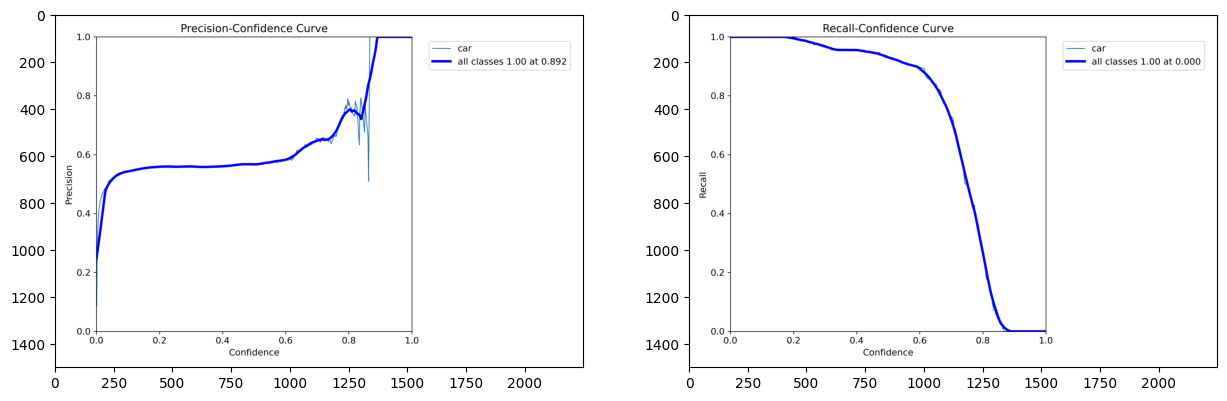

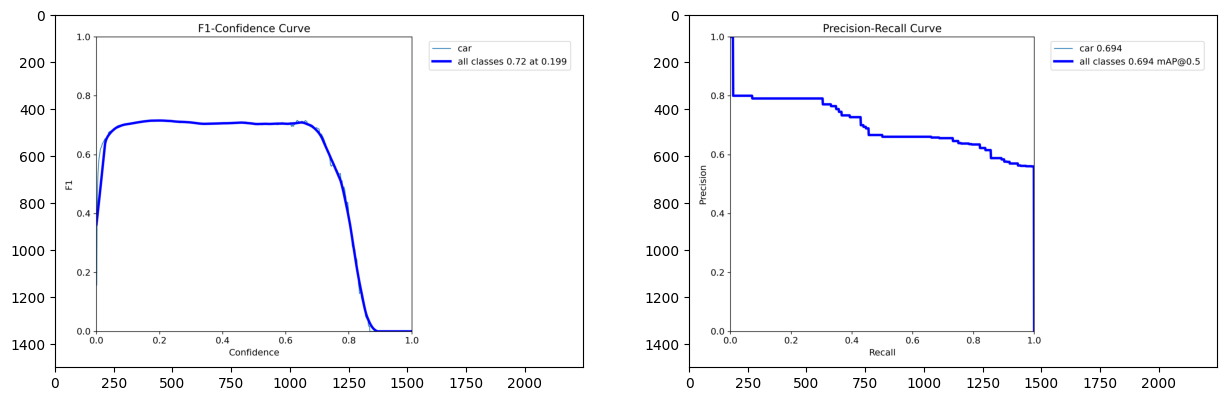

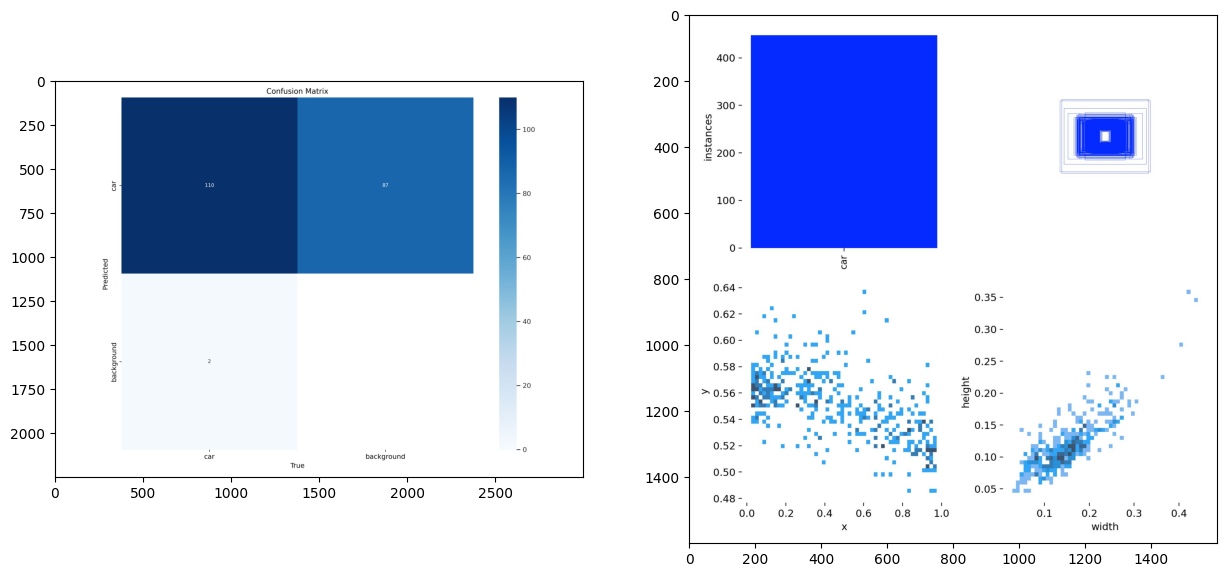

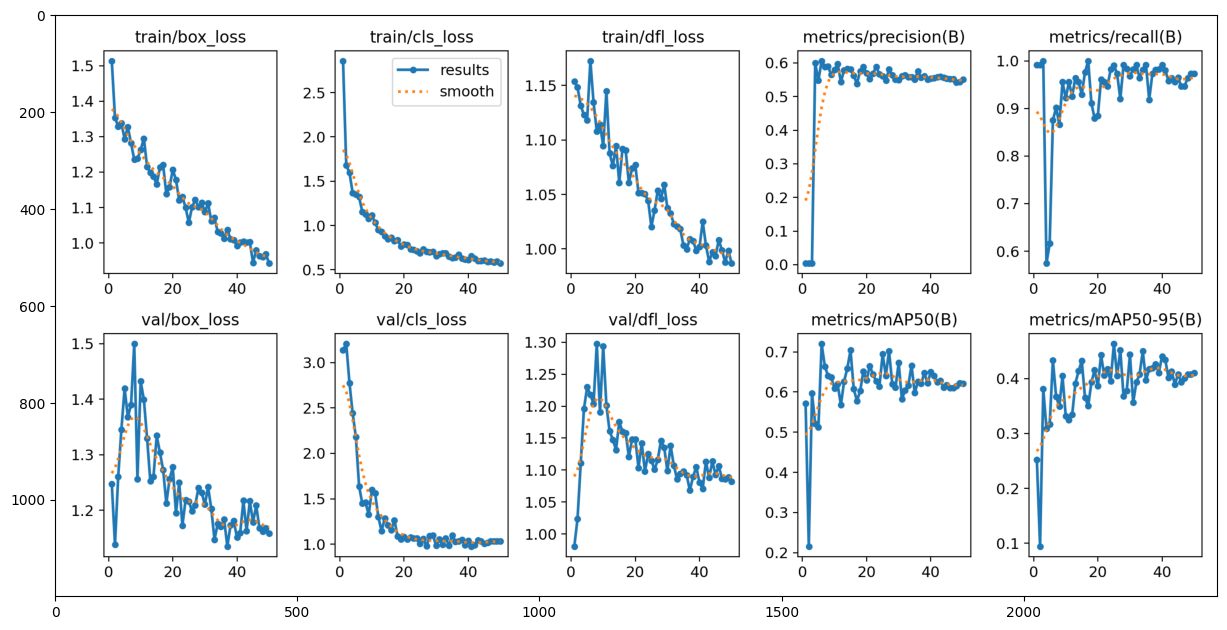

In [22]:
%matplotlib inline
model_path = '/kaggle/working/runs/detect/car_detection_model/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0], size[1], c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

<h2 align="center"><font color='green'> <span style="font-family:Roboto Mono;"> Test Model </span> </font></h2> 


image 1/1 /kaggle/working/dataset/images/test/vid_5_30180.jpg: 384x640 (no detections), 45.3ms
Speed: 1.8ms preprocess, 45.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


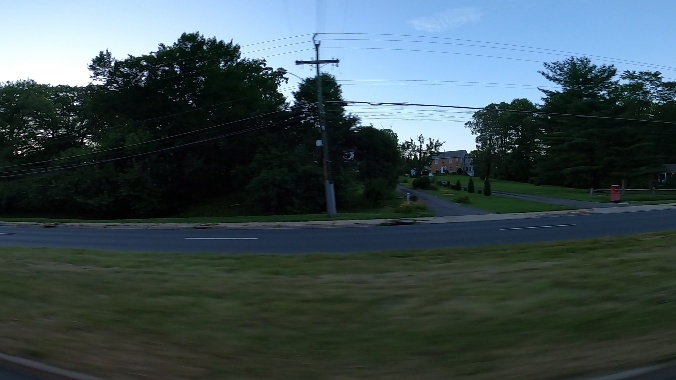


image 1/1 /kaggle/working/dataset/images/test/vid_5_26580.jpg: 384x640 1 car, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


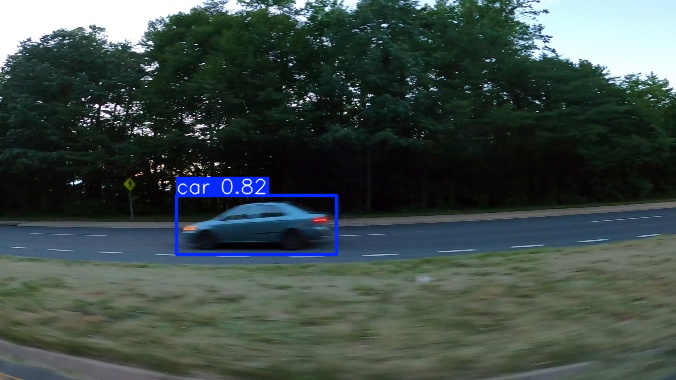


image 1/1 /kaggle/working/dataset/images/test/vid_5_27460.jpg: 384x640 2 cars, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


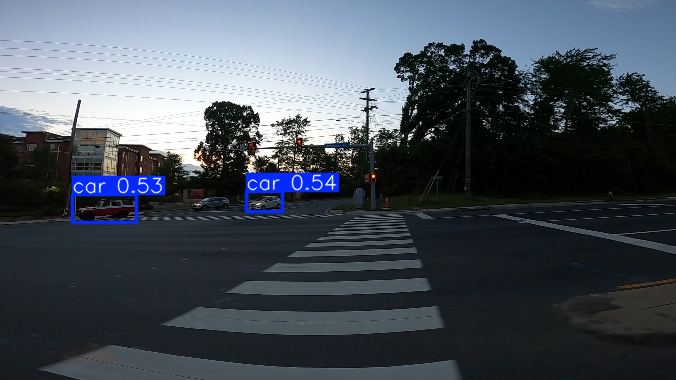


image 1/1 /kaggle/working/dataset/images/test/vid_5_29620.jpg: 384x640 (no detections), 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


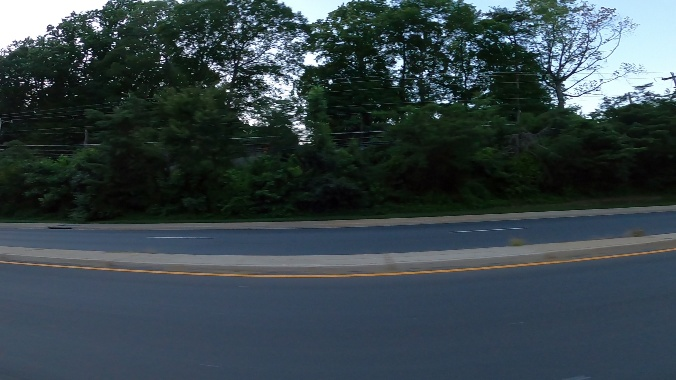


image 1/1 /kaggle/working/dataset/images/test/vid_5_26960.jpg: 384x640 1 car, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


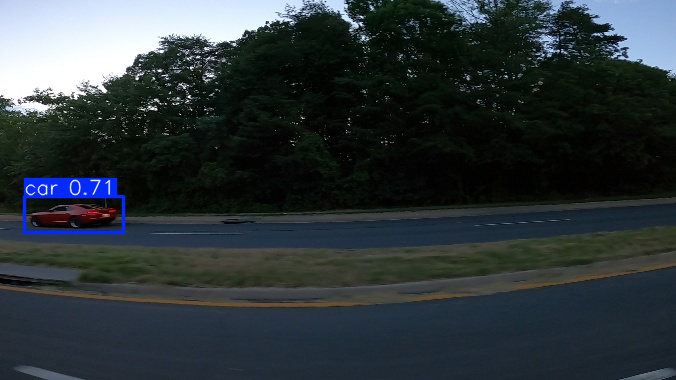


image 1/1 /kaggle/working/dataset/images/test/vid_5_27600.jpg: 384x640 (no detections), 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


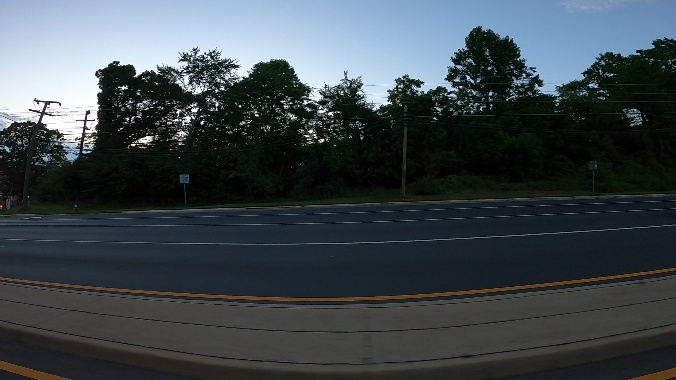

<Figure size 2000x2000 with 0 Axes>

In [23]:
images_path = '/kaggle/working/dataset/images/test/'

# choose random image from dataset
plt.figure(figsize=(20,20))
imgs = random.sample(os.listdir(images_path), 6)

for img in imgs:
    results = model(images_path+img)
    results[0].show()